# JhattaSamachaar Pretrained Transformer

In [1]:
!pip install transformers datasets torch rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=fe6274c98f941e1a6be930982411c531d818d7ac5efd24c15f1171b3d5ee265b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
# pip install --upgrade datasets

In [3]:
dataset_path = ["/kaggle/input/category-news/news.csv", "/kaggle/input/category-national/national.csv", "/kaggle/input/category-sports/sports.csv"]

In [4]:
import torch
from datasets import load_dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments

In [5]:
dataset = load_dataset('csv', data_files=dataset_path)

train_test_split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
train_dataset, val_dataset

(Dataset({
     features: ['article', 'highlights'],
     num_rows: 270
 }),
 Dataset({
     features: ['article', 'highlights'],
     num_rows: 31
 }))

In [7]:
model_name = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Preprocessng & Tokenization

In [8]:
def preprocess_function(examples):
    inputs = [f"summarize: {article}" for article in examples['article']]
    model_inputs = tokenizer(inputs, max_length=1024, padding='max_length', truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['highlights'], max_length=150, padding='max_length', truncation=True)

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [9]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/270 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/31 [00:00<?, ? examples/s]

## Training

In [10]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/pre_trained/results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    save_total_limit=3,
)

In [11]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [12]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,3.568319
2,No log,2.052719
3,No log,1.759142
4,No log,1.657180
5,No log,1.608901
6,No log,1.576740
7,No log,1.551366
8,No log,1.528823
9,No log,1.513456
10,No log,1.496842


TrainOutput(global_step=1700, training_loss=1.6027898451861213, metrics={'train_runtime': 780.0775, 'train_samples_per_second': 17.306, 'train_steps_per_second': 2.179, 'total_flos': 3654228639744000.0, 'train_loss': 1.6027898451861213, 'epoch': 50.0})

In [13]:
model.save_pretrained('/kaggle/working/pre_trained/model/pretrained_t5-small')
tokenizer.save_pretrained('/kaggle/working/pre_trained/model/pretrained_t5-small-tokenizer')

('/kaggle/working/pre_trained/model/pretrained_t5-small-tokenizer/tokenizer_config.json',
 '/kaggle/working/pre_trained/model/pretrained_t5-small-tokenizer/special_tokens_map.json',
 '/kaggle/working/pre_trained/model/pretrained_t5-small-tokenizer/spiece.model',
 '/kaggle/working/pre_trained/model/pretrained_t5-small-tokenizer/added_tokens.json')

## Loading the model

In [14]:
model = T5ForConditionalGeneration.from_pretrained('/kaggle/working/pre_trained/model/pretrained_t5-small')
tokenizer = T5Tokenizer.from_pretrained('/kaggle/working/pre_trained/model/pretrained_t5-small-tokenizer')

In [15]:
def summarize(article):
    inputs = tokenizer(f"summarize: {article}", return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [16]:
new_article = """Addressing public complaints, Prime Minister KP Sharma Oli has said that the government's top priority is how to conduct agile, sound, competent and transparent administration.

In the 53rd meeting of the National Development Problem Solution Committee held at Singhdarbar on Friday, Prime Minister Oli said that since good governance is more necessary for development, he has put governance reform at the top of the agenda to be decided by the committee.

He said that while protecting the forest environment, development projects should be facilitated in this area and forest-related agencies should not work in such a way as to hinder development. He referred to the fact that the Ministry of Forestry had sent more staff than necessary to the conference on climate in Baku, Azerbaijan, and drew the attention of ministers and secretaries that such wrong trends should not happen.

'We will have to act with speed and make bold decisions . Production and productivity should be increased by modernizing agriculture and encouraging the private sector. Acts of taunting and abusing entrepreneurs and getting applause with similar tendencies should be strictly discouraged,' Prime Minister Oli said, 'We should work by creating an environment for investment in business and industry . As a very big conspiracy, social chaos has been caused to hinder development.

Prime Minister Oli instructed the Ministry of Education to come up with alternative plans including online classes to improve the results of Secondary Education Examination Class 10 (SEE).

Government reforms presented at the meeting, use of forest area in national priority projects, project bank, district rates for public procurement purposes, operation of children's correctional homes and free street children campaign, government buildings at federal, state and local levels, supplementary grants, sixteen projects Implementation plan, multi-year contract management of projects, electricity tariff collection regulations, compulsory and free education, internship in public service, disaster resilient infrastructure construction, post-disaster reconstruction and rehabilitation. Decisions have been made in the agendas with solution options. In the

meeting, the Vice Chairman of the National Planning Commission, Shivraj Adhikari, discussed the state and trend of macroeconomic indicators, the state of Nepal government's public finance mobilization, the state of economic and social progress after federalism up to the current financial year, the state of the overall economic state of the provinces, the state of progress of the current financial year, and the previous three development problems. He made a presentation on the implementation status of the decision of the meeting of the solution committee.

Deputy Prime Minister and Finance Minister Bishnu Prasad Paudel, Ministers, Chief Ministers of State Governments, Chief Advisor to the Prime Minister, Governor of Nepal Rastra Bank, Chief Secretary of the Government of Nepal, Officials of the National Natural Resources and Finance Commission, Auditor General, Secretary of the Union and State Governments and others participated in the"""
summary = summarize(new_article)
print(summary)

Prime Minister KP Sharma Oli addressed public complaints about governance reforms at the 53rd meeting of the National Development Problem Solution Committee in Singhdarbar, Azerbaijan, on Friday. He emphasized the need for agile, sound, competent and transparent administration. He stressed that forest-related agencies should not work in such a way as to hinder development. He emphasized the importance of modernizing agriculture and encouraging private sector investment. He stressed that social chaos has been caused to hinder development.


In [17]:
from datasets import load_metric
import numpy as np

# Load the ROUGE metric
rouge = load_metric('rouge')

# Function to compute ROUGE scores
def compute_rouge(predictions, references):
    # Tokenize and decode predictions and references
    decoded_preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions]
    decoded_refs = [tokenizer.decode(ref, skip_special_tokens=True) for ref in references]

    # Compute ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_refs, use_stemmer=True)
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return result

# Example usage with your validation dataset
def evaluate_model(model, tokenizer, val_dataset):
    model.eval()
    predictions, references = [], []

    for batch in val_dataset:
        inputs = tokenizer(batch['article'], return_tensors='pt', max_length=1024, truncation=True)
        with torch.no_grad():
            summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
        predictions.extend(summary_ids)
        references.extend(batch['highlights'])

    rouge_scores = compute_rouge(predictions, references)
    return rouge_scores

# Calculate ROUGE scores for the validation dataset
rouge_scores = evaluate_model(model, tokenizer, val_dataset)
print(rouge_scores)

ImportError: cannot import name 'load_metric' from 'datasets' (/opt/conda/lib/python3.10/site-packages/datasets/__init__.py)

## Visualization

In [18]:
trainer.state.log_history

[{'eval_loss': 3.568319320678711,
  'eval_runtime': 0.612,
  'eval_samples_per_second': 50.653,
  'eval_steps_per_second': 6.536,
  'epoch': 1.0,
  'step': 34},
 {'eval_loss': 2.0527191162109375,
  'eval_runtime': 0.6126,
  'eval_samples_per_second': 50.601,
  'eval_steps_per_second': 6.529,
  'epoch': 2.0,
  'step': 68},
 {'eval_loss': 1.7591420412063599,
  'eval_runtime': 0.6112,
  'eval_samples_per_second': 50.722,
  'eval_steps_per_second': 6.545,
  'epoch': 3.0,
  'step': 102},
 {'eval_loss': 1.6571799516677856,
  'eval_runtime': 0.6112,
  'eval_samples_per_second': 50.722,
  'eval_steps_per_second': 6.545,
  'epoch': 4.0,
  'step': 136},
 {'eval_loss': 1.6089013814926147,
  'eval_runtime': 0.6115,
  'eval_samples_per_second': 50.699,
  'eval_steps_per_second': 6.542,
  'epoch': 5.0,
  'step': 170},
 {'eval_loss': 1.5767399072647095,
  'eval_runtime': 0.6106,
  'eval_samples_per_second': 50.768,
  'eval_steps_per_second': 6.551,
  'epoch': 6.0,
  'step': 204},
 {'eval_loss': 1.551

[1.6027898451861213] [3.568319320678711, 2.0527191162109375, 1.7591420412063599, 1.6571799516677856, 1.6089013814926147, 1.5767399072647095, 1.5513659715652466, 1.5288233757019043, 1.5134555101394653, 1.4968416690826416, 1.4882066249847412, 1.4779131412506104, 1.4692836999893188, 1.4621970653533936, 1.4571027755737305, 1.4508742094039917, 1.4479936361312866, 1.4425190687179565, 1.4400105476379395, 1.4378373622894287, 1.434049367904663, 1.4315907955169678, 1.4293713569641113, 1.4262555837631226, 1.4243701696395874, 1.4230730533599854, 1.4216400384902954, 1.4207217693328857, 1.4184905290603638, 1.4167450666427612, 1.415826678276062, 1.4148894548416138, 1.4138336181640625, 1.4129877090454102, 1.4125202894210815, 1.4120129346847534, 1.4116578102111816, 1.4109318256378174, 1.4102399349212646, 1.409593105316162, 1.4091017246246338, 1.408998966217041, 1.4084904193878174, 1.4081474542617798, 1.4080592393875122, 1.4077204465866089, 1.4075368642807007, 1.4074326753616333, 1.4074002504348755, 1.4

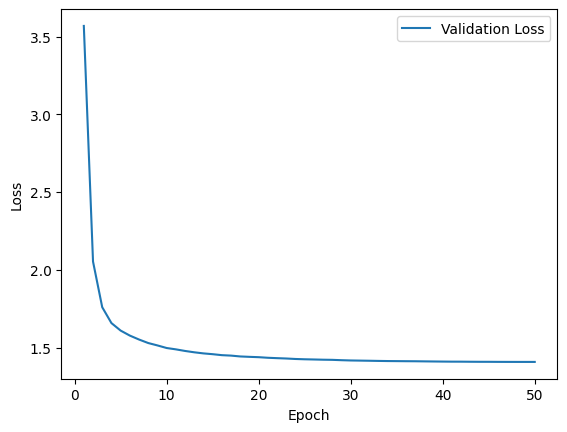

In [19]:
import matplotlib.pyplot as plt

# Load training logs
train_log = trainer.state.log_history

# Extract loss values
train_loss = [entry['train_loss'] for entry in train_log if 'train_loss' in entry.keys()]
eval_loss = [entry['eval_loss'] for entry in train_log if 'eval_loss' in entry.keys()]
print(train_loss, eval_loss)
# Ensure both lists have the same length
min_length = max(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]
epochs = range(1, min_length + 1)

# Plot training and evaluation loss
# plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
!zip -r file.zip /kaggle/working

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/wandb/ (stored 0%)
  adding: kaggle/working/wandb/debug.log (deflated 73%)
  adding: kaggle/working/wandb/latest-run/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/run-3ttauncp.wandb (deflated 77%)
  adding: kaggle/working/wandb/latest-run/tmp/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/tmp/code/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/logs/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/logs/debug.log (deflated 73%)
  adding: kaggle/working/wandb/latest-run/logs/debug-core.log (deflated 57%)
  adding: kaggle/working/wandb/latest-run/logs/debug-internal.log (deflated 76%)
  adding: kaggle/working/wandb/latest-run/files/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/files/wandb-metadata.json (deflated 47%)
  adding: kaggle/working/wandb/latest-run/files/output.log (deflated 43%)
  adding: kaggle/working/wandb/latest-run/files/requirements.txt (deflated 55%)
  adding: kaggle/wor